In [1]:
import io
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

/home/mynorjrv/Documents/mystuff/learning-machine-learning/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        random_state=42, n_estimators=200
    )
}

In [3]:
auto_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"
auto_columns = [
"symboling", "normalized_losses", "make", "fuel_type", "aspiration",
"num_doors", "body_style", "drive_wheels", "engine_location", "wheel_base",
"length", "width", "height", "curb_weight", "engine_type", "num_cylinders",
"engine_size", "fuel_system", "bore", "stroke", "compression_ratio",
"horsepower", "peak_rpm", "city_mpg", "highway_mpg", "price"
]

auto = pd.read_csv(auto_url, names=auto_columns, na_values="?")

In [4]:
auto = auto.dropna(subset=["price"])
auto["price"] = auto["price"].astype(float)

In [5]:
X_auto = auto.drop("price", axis=1)
y_auto = auto["price"]

In [23]:
len(X_auto.columns)

25

In [6]:
num_cols_auto = X_auto.select_dtypes(include=["int64", "float64"]).columns
cat_cols_auto = X_auto.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_auto = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols_auto),
        ("cat", categorical_transformer, cat_cols_auto)
    ]
)

In [15]:
pipeline_LR = Pipeline(
    steps=[
        ("preprocessor", preprocessor_auto),
        ("model", models["LinearRegression"])
    ]
)
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(
    X_auto, y_auto, test_size=0.2, random_state=42
)
pipeline_LR.fit(X_train_LR, y_train_LR)
y_pred_LR = pipeline_LR.predict(X_test_LR)
print(f"\nModelo: {"LinearRegression"}")
print("RMSE:", mean_squared_error(y_test_LR, y_pred_LR)) # , squared=False))
print("MAE:", mean_absolute_error(y_test_LR, y_pred_LR))
print("R²:", r2_score(y_test_LR, y_pred_LR))


Modelo: LinearRegression
RMSE: 10576265.63870383
MAE: 1972.1465065653358
R²: 0.9135550094847553


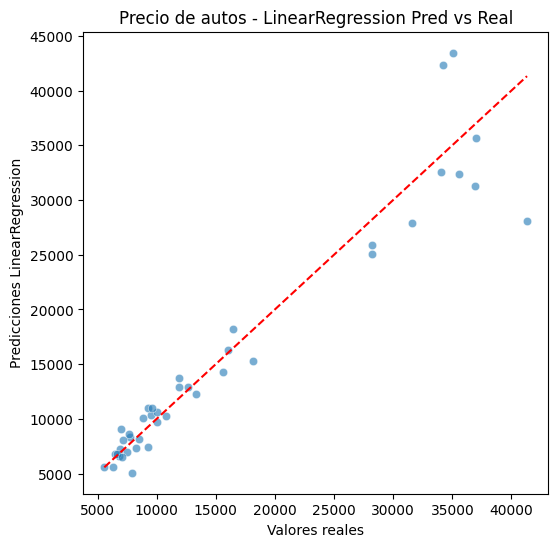

In [8]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_LR, y=y_pred_LR, alpha=0.6)
plt.plot([y_test_LR.min(), y_test_LR.max()], [y_test_LR.min(), y_test_LR.max()], "r--")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones LinearRegression")
plt.title("Precio de autos - LinearRegression Pred vs Real")
plt.show()

In [14]:
pipeline_RF = Pipeline(
    steps=[
        ("preprocessor", preprocessor_auto),
        ("model", models["RandomForest"])
    ]
)
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(
    X_auto, y_auto, test_size=0.2, random_state=42
)
pipeline_RF.fit(X_train_RF, y_train_RF)
y_pred_RF = pipeline_RF.predict(X_test_RF)
print(f"\nModelo: {"RandomForest"}")
print("RMSE:", mean_squared_error(y_test_RF, y_pred_RF)) # , squared=False))
print("MAE:", mean_absolute_error(y_test_RF, y_pred_RF))
print("R²:", r2_score(y_test_RF, y_pred_RF))


Modelo: RandomForest
RMSE: 8848236.0605072
MAE: 1886.835827235772
R²: 0.9276790401776509


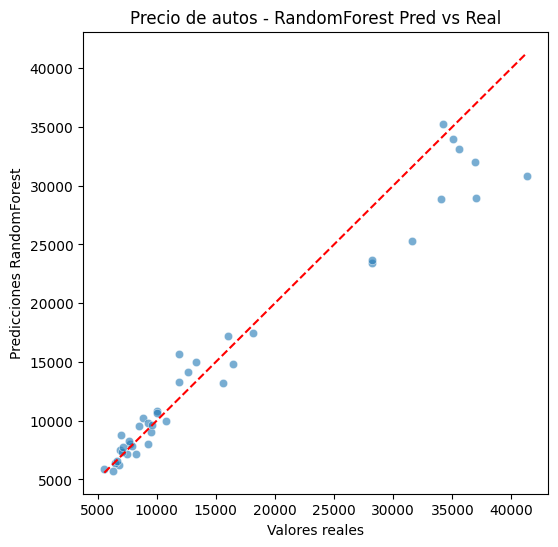

In [10]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_RF, y=y_pred_RF, alpha=0.6)
plt.plot([y_test_RF.min(), y_test_RF.max()], [y_test_RF.min(), y_test_RF.max()], "r--")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones RandomForest")
plt.title("Precio de autos - RandomForest Pred vs Real")
plt.show()

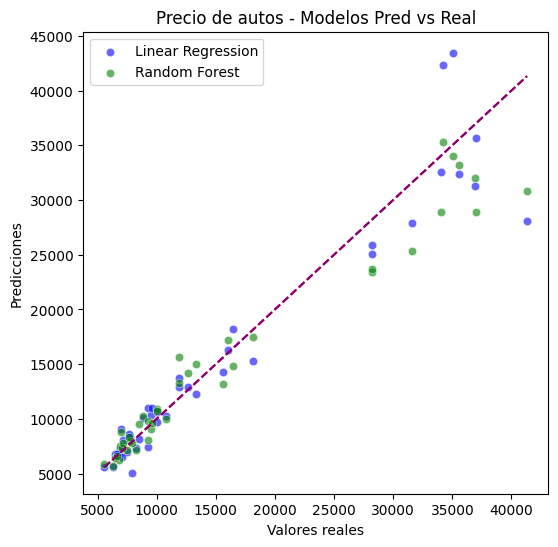

In [13]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_LR, y=y_pred_LR, alpha=0.6, color="blue", label="Linear Regression")
plt.plot([y_test_LR.min(), y_test_LR.max()], [y_test_LR.min(), y_test_LR.max()], "r--")
sns.scatterplot(x=y_test_RF, y=y_pred_RF, alpha=0.6, color="green", label="Random Forest")
plt.plot([y_test_RF.min(), y_test_RF.max()], [y_test_RF.min(), y_test_RF.max()], "--", color="purple")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Precio de autos - Modelos Pred vs Real")
plt.legend()
plt.show()

In [25]:
len(
    num_cols_auto.tolist()
    +cat_cols_auto.tolist()
)

25

In [31]:
# pipeline_RF.named_steps["preprocessor"].get_feature_names_out(num_cols_auto.tolist() + cat_cols_auto.tolist())

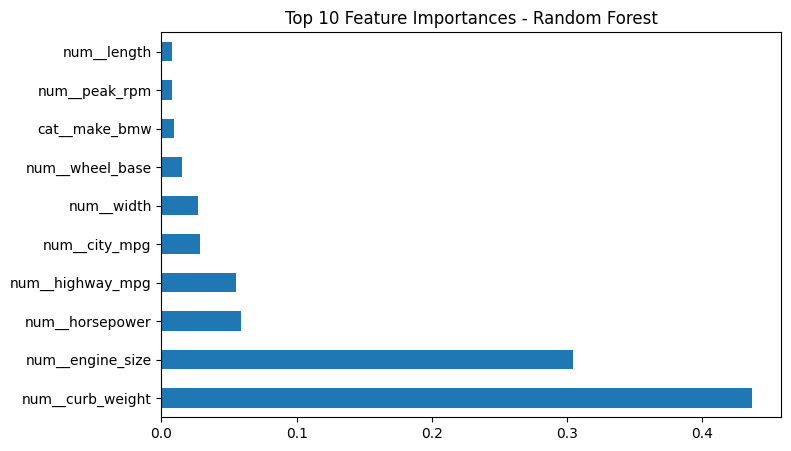

In [34]:
feature_names = (
    pipeline_RF
    .named_steps["preprocessor"]
    .get_feature_names_out(
        # num_cols_auto.tolist()
        # + cat_cols_auto.tolist()
    )
)

# feature_names = [num_cols_auto.tolist() + cat_cols_auto.tolist()]

importances = pipeline_RF.named_steps["model"].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()

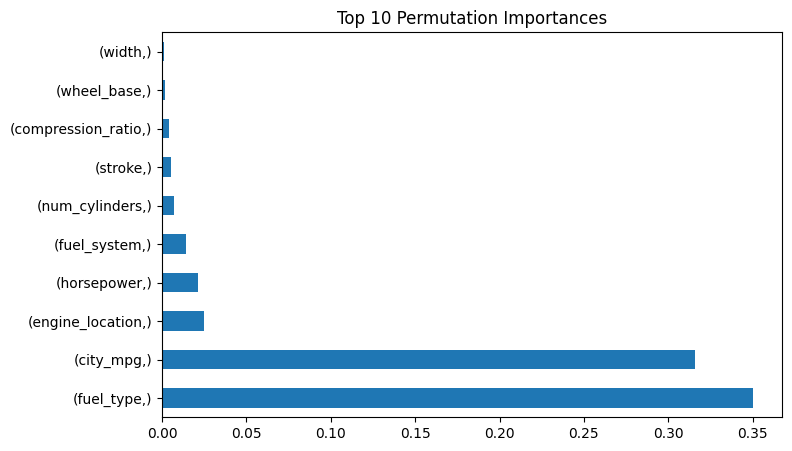

In [32]:
from sklearn.inspection import permutation_importance

feature_names = [num_cols_auto.tolist() + cat_cols_auto.tolist()]

perm = permutation_importance(pipeline_RF, X_test_RF, y_test_RF, n_repeats=10, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
perm_importances.head(10).plot(kind="barh")
plt.title("Top 10 Permutation Importances")
plt.show()